# Boris Ryzhyi poetry generator


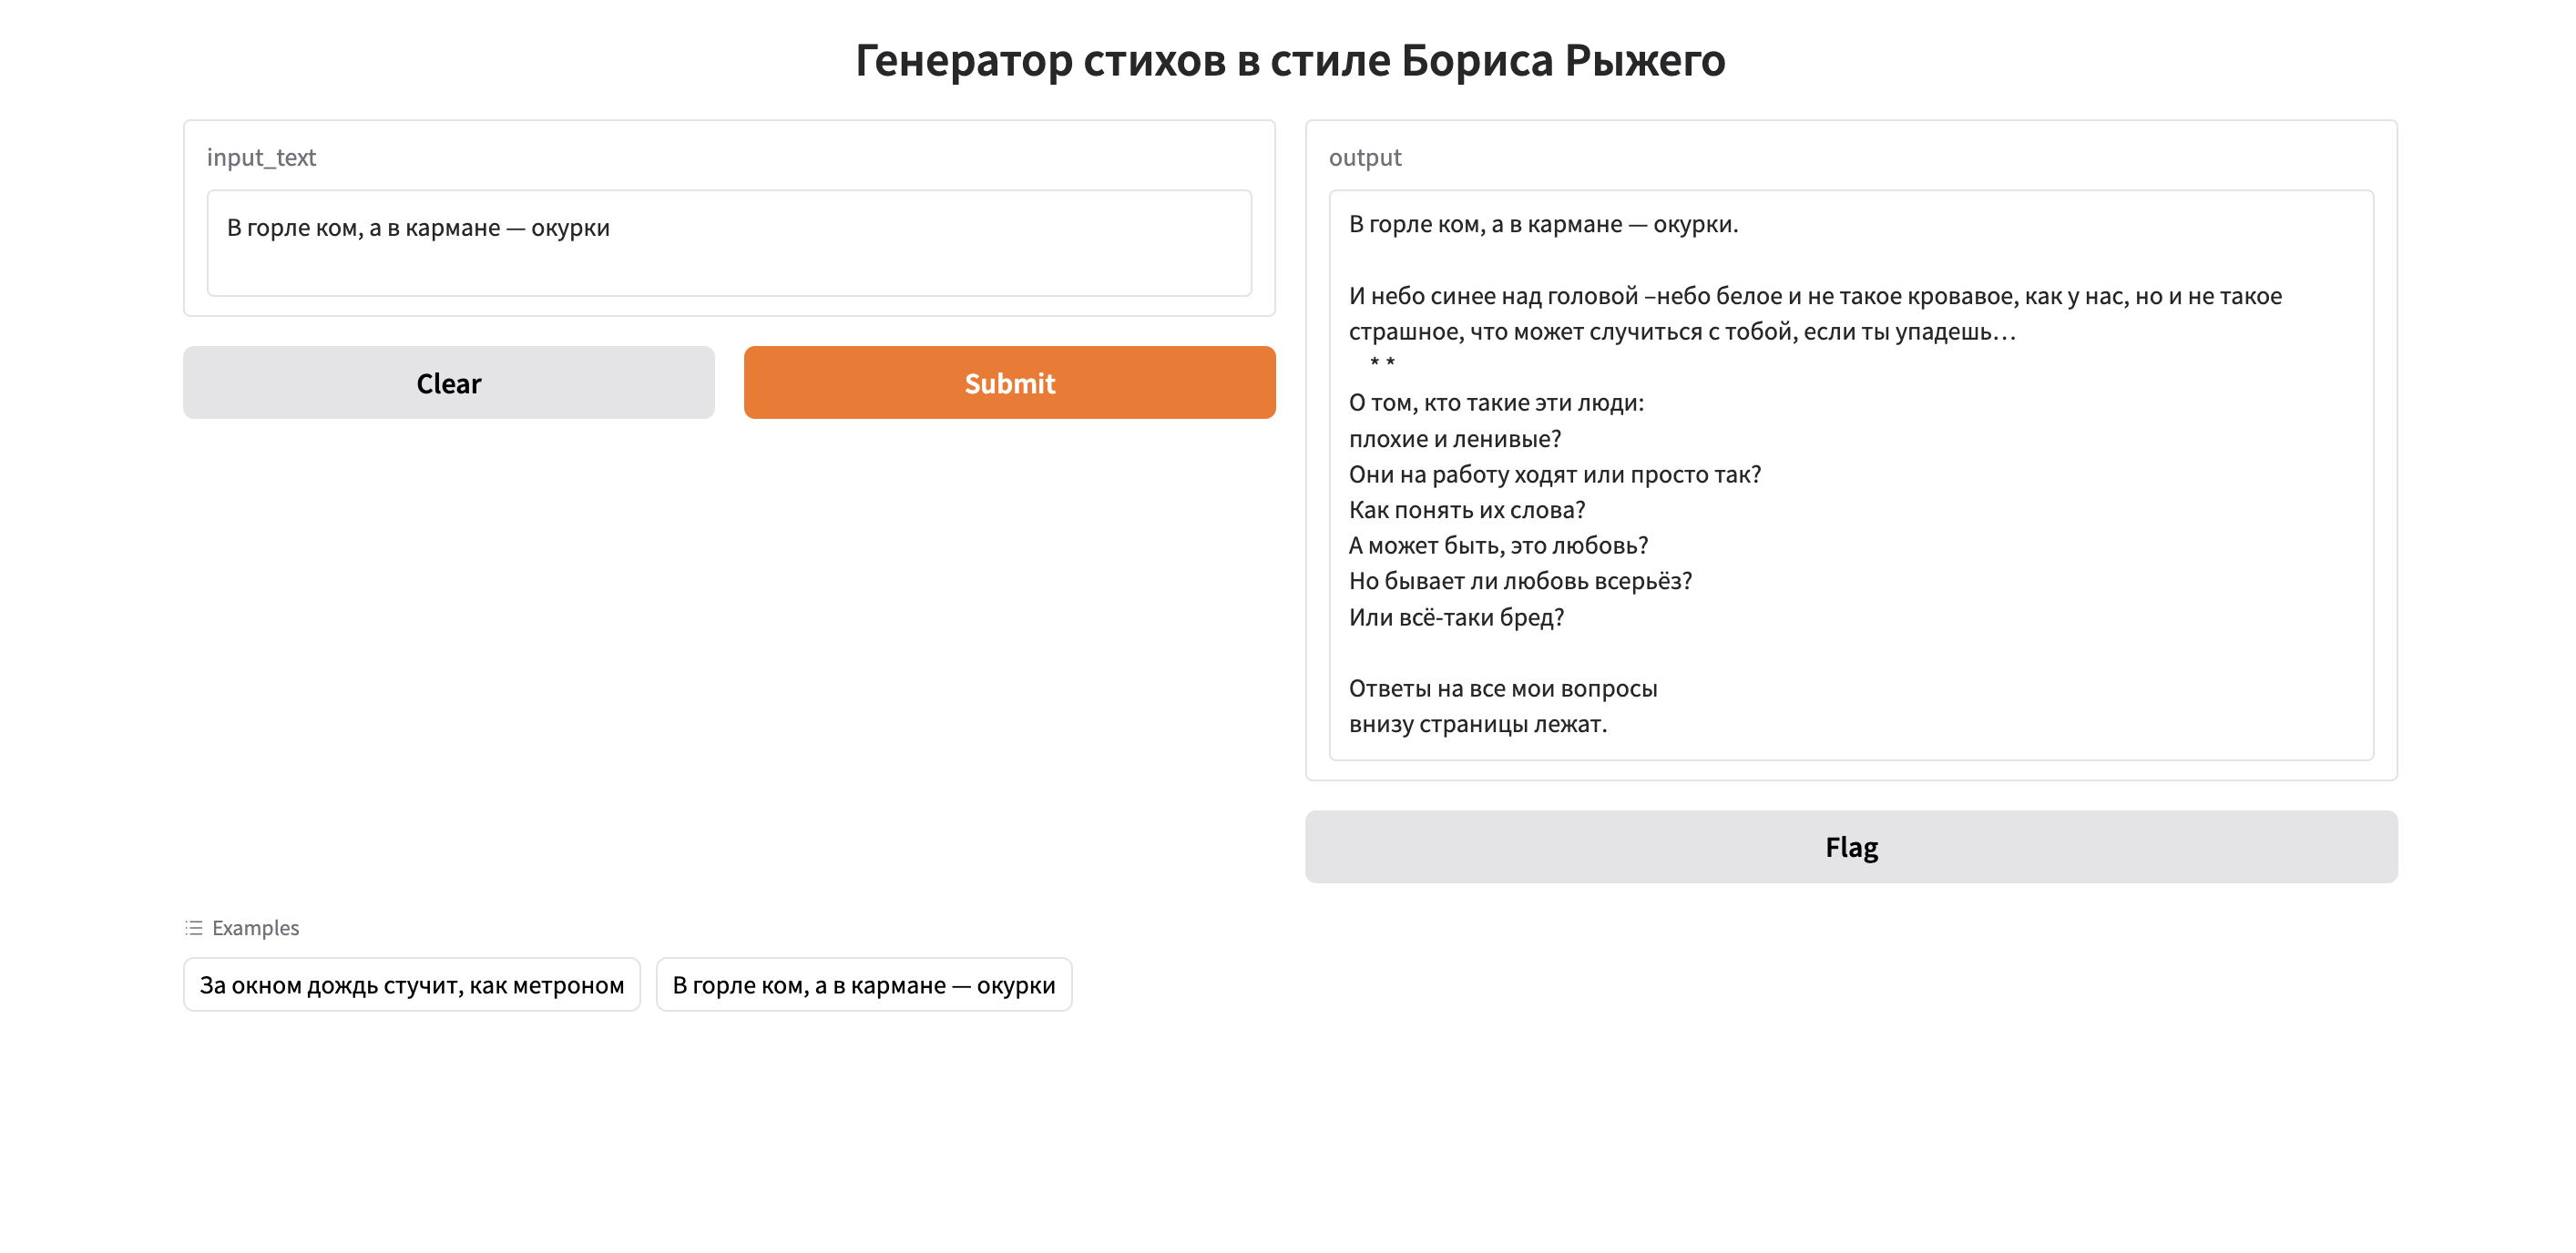

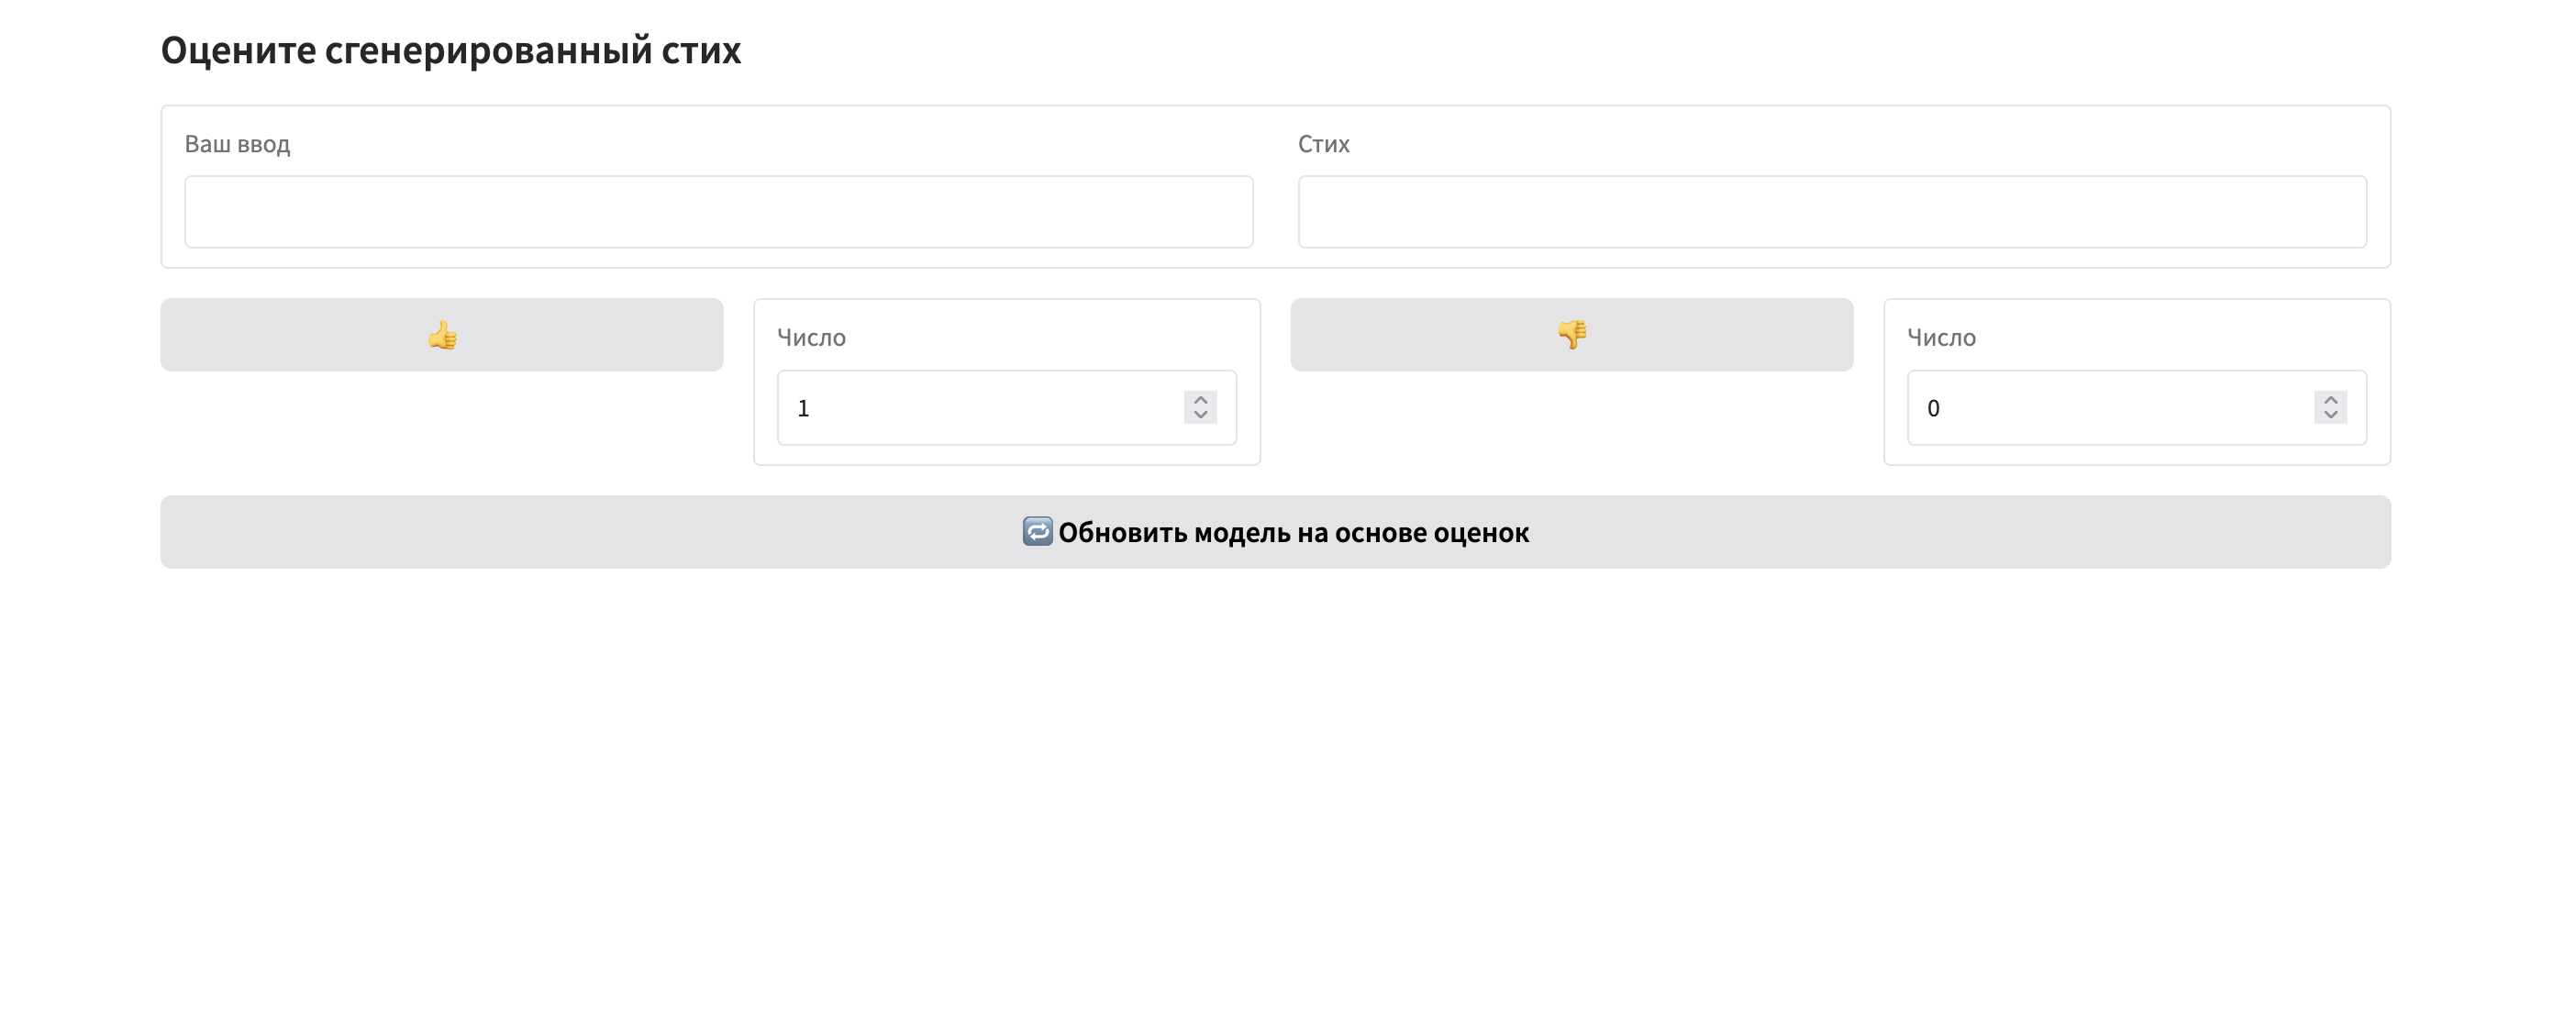

In [1]:
# Установка зависимостей
!pip install transformers datasets torch gradio sentencepiece accelerate

# Импорт библиотек
from transformers import GPT2LMHeadModel, GPT2Tokenizer, Trainer, TrainingArguments
from datasets import Dataset
import torch
import gradio as g

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import torch
torch.cuda.empty_cache()

# Настройка переменных окружения
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [3]:
# Загрузка и подготовка датасета
!wget https://raw.githubusercontent.com/pltnv-a-a/nlp-notes/refs/heads/main/Boris_Ryzhyi.txt

with open('Boris_Ryzhyi.txt', 'r', encoding='utf-8') as f:
    texts = f.read().split('\n\n')  # Разделяем на отдельные стихотворения

# Создаем датасет
dataset = Dataset.from_dict({"text": texts})

--2025-05-26 15:40:31--  https://raw.githubusercontent.com/pltnv-a-a/nlp-notes/refs/heads/main/Boris_Ryzhyi.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45177 (44K) [text/plain]
Saving to: ‘Boris_Ryzhyi.txt’

Boris_Ryzhyi.txt    100%[===================>]  44.12K  --.-KB/s    in 0.001s  

2025-05-26 15:40:31 (35.7 MB/s) - ‘Boris_Ryzhyi.txt’ saved [45177/45177]



In [4]:
print(dataset[-1000:-1])

{'text': ['Борис Рыжий\n* * *', '\xa0', '...Врывается, перебивая Баха,', 'я не виню ее – стена моя тонка.', 'Блатная музыка, ни горечи, ни страха,', 'одно невежество, бессмыслица, тоска.', 'Шальная, наглая, как будто нету смерти,', 'девица липкая, глаза как два нуля.', '...И что мне Бранденбургские концерты,', 'зачем мне жизнь моя, что стоит жизнь моя?', '\xa0', '1996', '', '* * *', '\xa0', '«В белом поле был пепельный бал...» –', 'вслух читал, у гостей напиваясь,', 'перед сном как молитву шептал,', 'а теперь и не вспомнить, признаюсь.', '\xa0', 'Над великой рекой постою,', 'где алеет закат, догорая.', 'Вы вошли слишком просто в мою', 'жизнь – играючи и умирая.', '\xa0', 'Навязали свои дневники,', 'письма, комплексы, ветви сирени.', 'За моею спиной у реки', 'вы толпитесь, печальные тени.', '\xa0', 'Уходите, вы слышите гул –', 'вроде грохота, грома, раската.', 'Может быть, и меня полоснул', 'тонким лезвием лучик заката.', '\xa0', 'Не один ещё юный кретин', 'вам доверит грошовое горе.', 

In [5]:
# Токенизатор и модель
model_name = "ai-forever/rugpt3small_based_on_gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

def preprocess(examples):
    tokenized = tokenizer(
        examples["text"],
        truncation=True,
        max_length=128,
        padding="max_length",
        add_special_tokens=True
    )
    # Явно добавляем labels = input_ids для вычисления loss
    tokenized["labels"] = tokenized["input_ids"].copy()
    return tokenized

tokenized_dataset = dataset.map(preprocess, batched=True, remove_columns=["text"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

Map:   0%|          | 0/386 [00:00<?, ? examples/s]

In [6]:
# Обучение
model = GPT2LMHeadModel.from_pretrained(model_name)

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=4,
    num_train_epochs=5,  # Большое к эпох для тонкой настройки
    learning_rate=3e-5,
    gradient_checkpointing=True,
    logging_dir="./logs",
    save_strategy="epoch",
    fp16=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
)

trainer.train()


config.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/551M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/551M [00:00<?, ?B/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: a-a-pltnv (a-a-pltnv-spbsu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss


TrainOutput(global_step=485, training_loss=0.6023528738120167, metrics={'train_runtime': 196.544, 'train_samples_per_second': 9.82, 'train_steps_per_second': 2.468, 'total_flos': 126073405440000.0, 'train_loss': 0.6023528738120167, 'epoch': 5.0})

In [7]:
# Генерация
def generate_poetry(input_text):
    # Токенизация и перемещение данных на GPU
    inputs = tokenizer(input_text, return_tensors="pt", max_length=64, truncation=True)
    inputs = inputs.to(model.device)  # Автоматически определяет устройство модели (cuda/cpu)

    # Генерация с включенным сэмплированием
    outputs = model.generate(
        inputs.input_ids,
        max_length=128,
        num_return_sequences=1,
        temperature=0.7, # Меньше "случайности" для поэзии
        top_p=0.9,
        repetition_penalty=1.2, # Избегаем повторов
        do_sample=True,  # параметр для temperature и top_p
        pad_token_id=tokenizer.eos_token_id,
    )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)


In [13]:
# Демо-приложение
!pip install trl
from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead
from transformers import GPT2Tokenizer

torch.cuda.empty_cache()

examples = [
    "За окном дождь стучит, как метроном",
    "В горле ком, а в кармане — окурки"
]

interface = g.Interface(
    fn=generate_poetry,
    inputs=g.Textbox(lines=2, placeholder="Начните стихотворение..."),
    outputs="text",
    title="Генератор стихов в стиле Бориса Рыжего",
    examples=examples
)

interface.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://43cda8c1f60c89e3fc.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7864 <> https://43cda8c1f60c89e3fc.gradio.live


In [14]:
# RLHF

def rate_poetry(input_text, generated_text, rating):
    # Логируем оценку в файл
    with open("feedback.txt", "a") as f:
        f.write(f"{input_text}|{generated_text}|{rating}\n")
    return "Спасибо за оценку!"

def train_with_feedback():
    # Загрузка данных
    with open("feedback.txt", "r") as f:
        feedback = [line.strip().split("|") for line in f.readlines()]

    # Подготовка данных
    queries = [item[0] for item in feedback]
    responses = [item[1] for item in feedback]
    rewards = [float(item[2]) for item in feedback]

    model_rlhf = AutoModelForCausalLMWithValueHead.from_pretrained("./results")
    tokenizer_rlhf = GPT2Tokenizer.from_pretrained("./results")

    # Конфигурация PPO
    ppo_config = PPOConfig(
        batch_size=2,
        learning_rate=1e-5,
        steps=100
    )

    # Инициализация тренера
    ppo_trainer = PPOTrainer(
        model=model_rlhf,
        config=ppo_config,
        tokenizer=tokenizer_rlhf,
        dataset=queries,
    )

    # Обучение
    for step in range(ppo_config.steps):
        stats = ppo_trainer.step(queries, responses, rewards)
        print(f"Step {step}: Reward = {stats['ppo/mean_scores']}")

    # Очистка файла после обучения
    open("feedback.txt", "w").close()

def train_and_notify():
    # Запуск обучения и возврат статуса
    try:
        train_with_feedback()
        return "Модель успешно обновлена!"
    except Exception as e:
        return f"Ошибка: {str(e)}"

demo = g.Blocks()
with demo:
    g.Markdown("## Оцените сгенерированный стих")
    with g.Row():
        inp = g.Textbox(label="Ваш ввод")
        out = g.Textbox(label="Стих")
    with g.Row():
        g.Button("👍").click(fn=rate_poetry, inputs=[inp, out, g.Number(1)])
        g.Button("👎").click(fn=rate_poetry, inputs=[inp, out, g.Number(0)])

    # Секция для обучения
    with g.Row():
        train_btn = g.Button("🔁 Обновить модель на основе оценок")

    # Обработчики
    train_btn.click(
        fn=train_and_notify
    )

    # Автоматическое обучение каждые 5 минут
    demo.load(
        fn=lambda: None,
        outputs=None,
        stream_every=300  # 300 секунд = 5 минут
    )

demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://86aa92827da031fff3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
